# Initial Setup 

In [86]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import cohen_kappa_score
from scipy import stats
import warnings

# Suppressing warnings
warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.color_palette("hls", 7)

# Display full column content and all columns
pd.set_option('display.max_columns', None)        # Show all columns
pd.set_option('display.max_colwidth', None)       # Don't truncate column text
pd.set_option('display.expand_frame_repr', True)  # Prevent column wrapping
pd.set_option('display.float_format', '{:,.3f}'.format)

In [87]:
#loading the dataset
data = pd.read_csv('../data/merged_output.csv')

# cretating a copy of the dataframe to avoid modifying the original data
df = data.copy()
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.sample(5)

Dataset shape: (536, 9)
Columns: ['image_url', 'labeller1_label', 'labeller2_label', 'model_a_too_dark', 'model_a_blur', 'model_a_normal_image_quality', 'model_b_too_dark', 'model_b_blur', 'model_b_normal_image_quality']


,image_url,labeller1_label,labeller2_label,model_a_too_dark,model_a_blur,model_a_normal_image_quality,model_b_too_dark,model_b_blur,model_b_normal_image_quality
137,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/dbb91b32-c3cd-4090-99ad-00921f1e87f3.jpg,too_dark,too_dark,0.997,0.004,0.006,0.994,0.011,0.011
99,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/3081460d-f891-4782-b49d-fef36cc2afa0.jpg,blur,blur,0.004,0.996,0.013,0.007,0.995,0.005
153,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/6e36d66a-5ddc-41b5-8384-ba695dc26dbd.jpg,blur,blur,0.006,0.997,0.009,0.007,0.993,0.009
347,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/f47be399-aa42-4917-a56b-4ca42aa11095.jpg,too_dark,too_dark,0.980,0.013,0.019,0.994,0.007,0.009
36,https://storage.googleapis.com/captur-synthetic-datasets/image_quality/44b94d62-f655-4fd7-af77-760d6278726d.jpg,too_dark,too_dark,0.996,0.005,0.006,0.994,0.010,0.010


**Insight** : Labellers seem so disagree about certain images. suggesting to deep dive into the issue to establish ground truth about model A and model b predictions 

# EDA

## Data inspection


In [88]:
df.describe()

,model_a_too_dark,model_a_blur,model_a_normal_image_quality,model_b_too_dark,model_b_blur,model_b_normal_image_quality
count,536.000,536.000,536.000,536.000,536.000,536.000
mean,0.235,0.394,0.378,0.253,0.306,0.475
std,0.396,0.460,0.450,0.409,0.436,0.483
min,0.001,0.002,0.000,0.001,0.001,0.001
25%,0.006,0.007,0.008,0.007,0.007,0.008
50%,0.010,0.021,0.027,0.011,0.011,0.070
75%,0.240,0.989,0.974,0.475,0.958,0.991
max,0.999,0.999,0.998,0.998,0.998,0.998


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   image_url                     536 non-null    object 
 1   labeller1_label               536 non-null    object 
 2   labeller2_label               536 non-null    object 
 3   model_a_too_dark              536 non-null    float64
 4   model_a_blur                  536 non-null    float64
 5   model_a_normal_image_quality  536 non-null    float64
 6   model_b_too_dark              536 non-null    float64
 7   model_b_blur                  536 non-null    float64
 8   model_b_normal_image_quality  536 non-null    float64
dtypes: float64(6), object(3)
memory usage: 37.8+ KB


Insights: 
- no missing values in any column data appears to be cleaned and ready for analysis

## Labeller analysis

In [90]:
# Check Labeller Consistency to establish single source of truth

df['agreement'] = df['labeller1_label'] == df['labeller2_label']
df['disagreement'] = df['labeller1_label'] != df['labeller2_label']

df['ground_truth'] = df.apply(lambda x: x['labeller1_label'] if x['labeller1_label'] == x['labeller2_label'] else 'disagreement', axis=1)
df['ground_truth'] = df['ground_truth'].replace({'normal': 'normal_image_quality'})

# Ground truth distribution
print("\n=== GROUND TRUTH LABELS ===\n")
print(f"Labeller agreement rate: {df['agreement'].mean():.3f}")
print(f"Disagreement cases: {df['disagreement'].sum()}")
print(f"\nGround truth distribution:\n{df['ground_truth'].value_counts()}")



=== GROUND TRUTH LABELS ===

Labeller agreement rate: 0.707
Disagreement cases: 157

Ground truth distribution:
ground_truth
normal_image_quality    186
disagreement            157
blur                    100
too_dark                 93
Name: count, dtype: int64


In [91]:
# Ground truth class distribution analysis
print("\n=== GROUND TRUTH CLASS DISTRIBUTIONS ===")
labeller1_dist = df['labeller1_label'].value_counts(normalize=True)
labeller2_dist = df['labeller2_label'].value_counts(normalize=True)

print("Labeller 1 distribution:")
for class_name, pct in labeller1_dist.items():
    print(f"  {class_name}: {pct:.1%} ({df['labeller1_label'].value_counts()[class_name]} images)")

print("\nLabeller 2 distribution:")
for class_name, pct in labeller2_dist.items():
    print(f"  {class_name}: {pct:.1%} ({df['labeller2_label'].value_counts()[class_name]} images)")


=== GROUND TRUTH CLASS DISTRIBUTIONS ===
Labeller 1 distribution:
  normal: 40.3% (216 images)
  blur: 36.2% (194 images)
  too_dark: 23.5% (126 images)

Labeller 2 distribution:
  normal: 50.9% (273 images)
  blur: 27.2% (146 images)
  too_dark: 21.8% (117 images)


In [92]:
# Calculate Cohen's Kappa for labeller agreement
labeller1_encoded = pd.Categorical(df['labeller1_label']).codes
labeller2_encoded = pd.Categorical(df['labeller2_label']).codes
kappa = cohen_kappa_score(labeller1_encoded, labeller2_encoded)
print(f"Cohen's Kappa (inter-labeller agreement): {kappa:.3f}")


Cohen's Kappa (inter-labeller agreement): 0.546


Kappa value of 0.546 suggests **Moderate agreement**.

**Explanation:**

- The two labellers agreed more than by chance, but disagreements are still common.

- Since ground truth (GT) is built from these labels, its reliability is moderate, not strong.

- This introduces label noise, which affects model training and evaluation.

**Delivery verical use case**

| Insight                                     | Implication                                                                                                                                           |
| ------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- |
|  **Moderate labeller agreement**          | Ground truth is not perfectly reliable; model comparisons based on this GT should be interpreted cautiously                                           |
| **Some images are inherently ambiguous** | Likely borderline cases for "blur" or "too\_dark", suggesting subjectivity in labelling                                                               |
| **Human perception of quality varies**   | In delivery, which has **higher quality expectations**, this variance could result in **missed blurry/dark photos** unless well-defined rubric exists |
| **Reinforce labelling instructions**     | A labelling rubric and calibration sessions can improve consistency                                                                                   |
| **Disagreement cases are valuable**      | Can be used for active learning, labeller re-alignment, or as **edge cases for model improvement**                                                    |


## Model Distributions

In [93]:
# Model A distributions
model_a_cols = ['model_a_too_dark', 'model_a_blur', 'model_a_normal_image_quality']
model_b_cols = ['model_b_too_dark', 'model_b_blur', 'model_b_normal_image_quality']

print("MODEL A - Class Probability Statistics:")
print(df[model_a_cols].describe())
print("\nMODEL B - Class Probability Statistics:")
print(df[model_b_cols].describe())

MODEL A - Class Probability Statistics:
       model_a_too_dark  model_a_blur  model_a_normal_image_quality
count           536.000       536.000                       536.000
mean              0.235         0.394                         0.378
std               0.396         0.460                         0.450
min               0.001         0.002                         0.000
25%               0.006         0.007                         0.008
50%               0.010         0.021                         0.027
75%               0.240         0.989                         0.974
max               0.999         0.999                         0.998

MODEL B - Class Probability Statistics:
       model_b_too_dark  model_b_blur  model_b_normal_image_quality
count           536.000       536.000                       536.000
mean              0.253         0.306                         0.475
std               0.409         0.436                         0.483
min               0.001         0.0

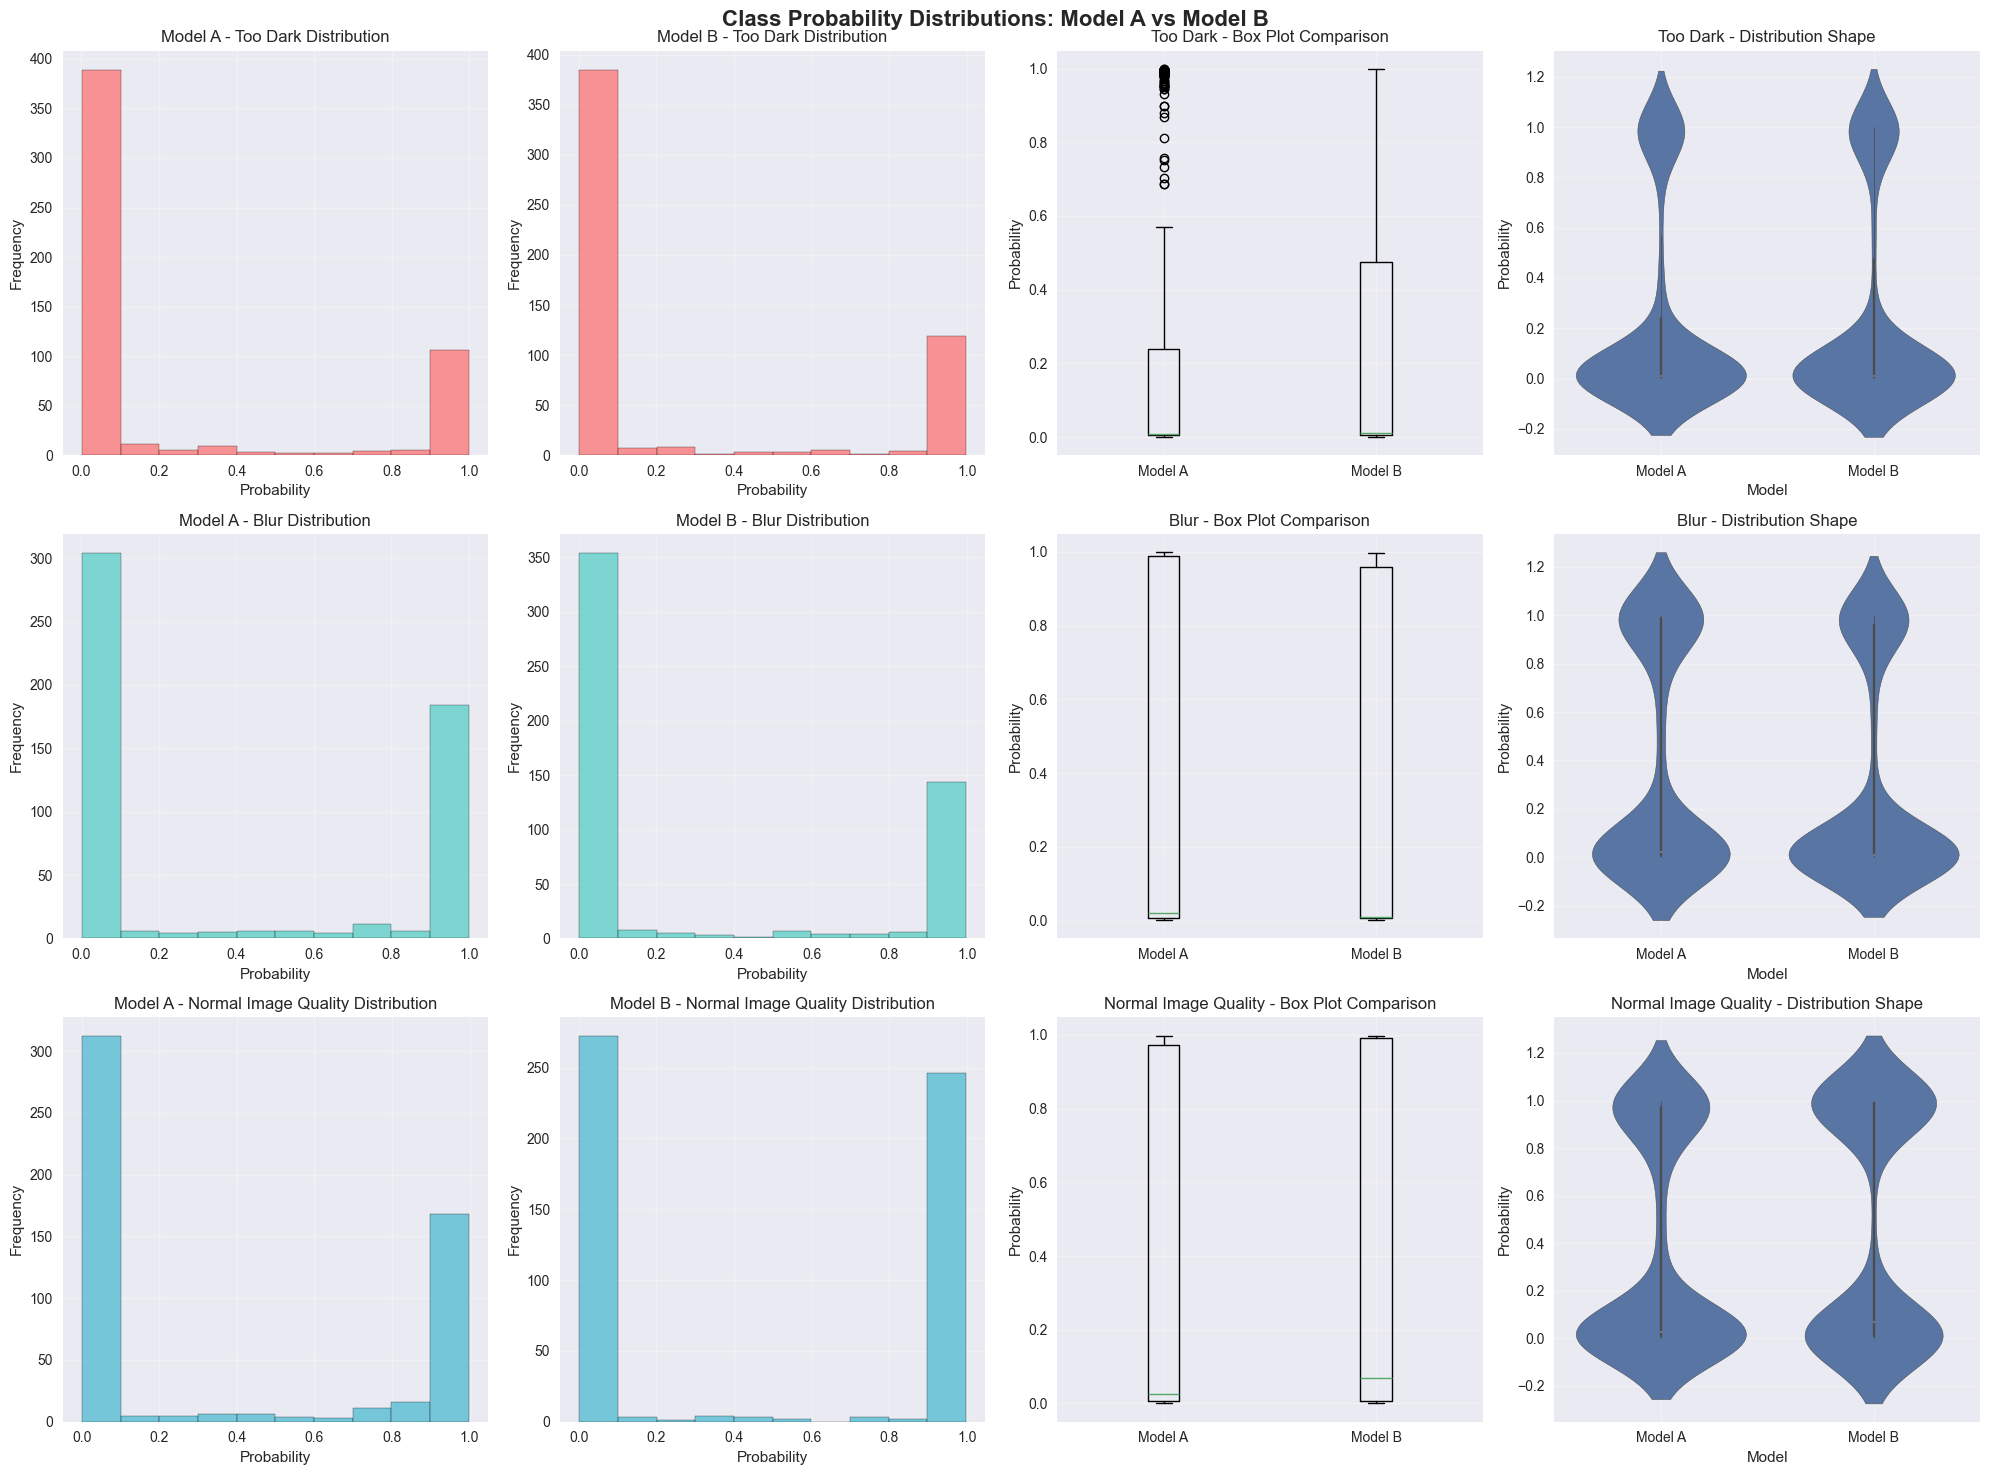

In [94]:
# Distribution plots for Model A and Model B
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Class Probability Distributions: Model A vs Model B', fontsize=16, fontweight='bold')

classes = ['too_dark', 'blur', 'normal_image_quality']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, class_name in enumerate(classes):
    col_a = f'model_a_{class_name}'
    col_b = f'model_b_{class_name}'
    
    # Histograms
    axes[i, 0].hist(df[col_a], bins=10, alpha=0.7, color=colors[i], edgecolor='black')
    axes[i, 0].set_title(f'Model A - {class_name.replace("_", " ").title()} Distribution')
    axes[i, 0].set_xlabel('Probability')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].grid(True, alpha=0.3)
    
    axes[i, 1].hist(df[col_b], bins=10, alpha=0.7, color=colors[i], edgecolor='black')
    axes[i, 1].set_title(f'Model B - {class_name.replace("_", " ").title()} Distribution')
    axes[i, 1].set_xlabel('Probability')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].grid(True, alpha=0.3)
    
    # Box plots for outlier detection
    axes[i, 2].boxplot([df[col_a], df[col_b]], labels=['Model A', 'Model B'])
    axes[i, 2].set_title(f'{class_name.replace("_", " ").title()} - Box Plot Comparison')
    axes[i, 2].set_ylabel('Probability')
    axes[i, 2].grid(True, alpha=0.3)
    
    # Violin plots for distribution shape
    data_for_violin = pd.DataFrame({
        'Model A': df[col_a],
        'Model B': df[col_b]
    })
    data_melted = data_for_violin.melt(var_name='Model', value_name='Probability')
    sns.violinplot(data=data_melted, x='Model', y='Probability', ax=axes[i, 3])
    axes[i, 3].set_title(f'{class_name.replace("_", " ").title()} - Distribution Shape')
    axes[i, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


3. DISTRIBUTION BY GROUND TRUTH LABELS


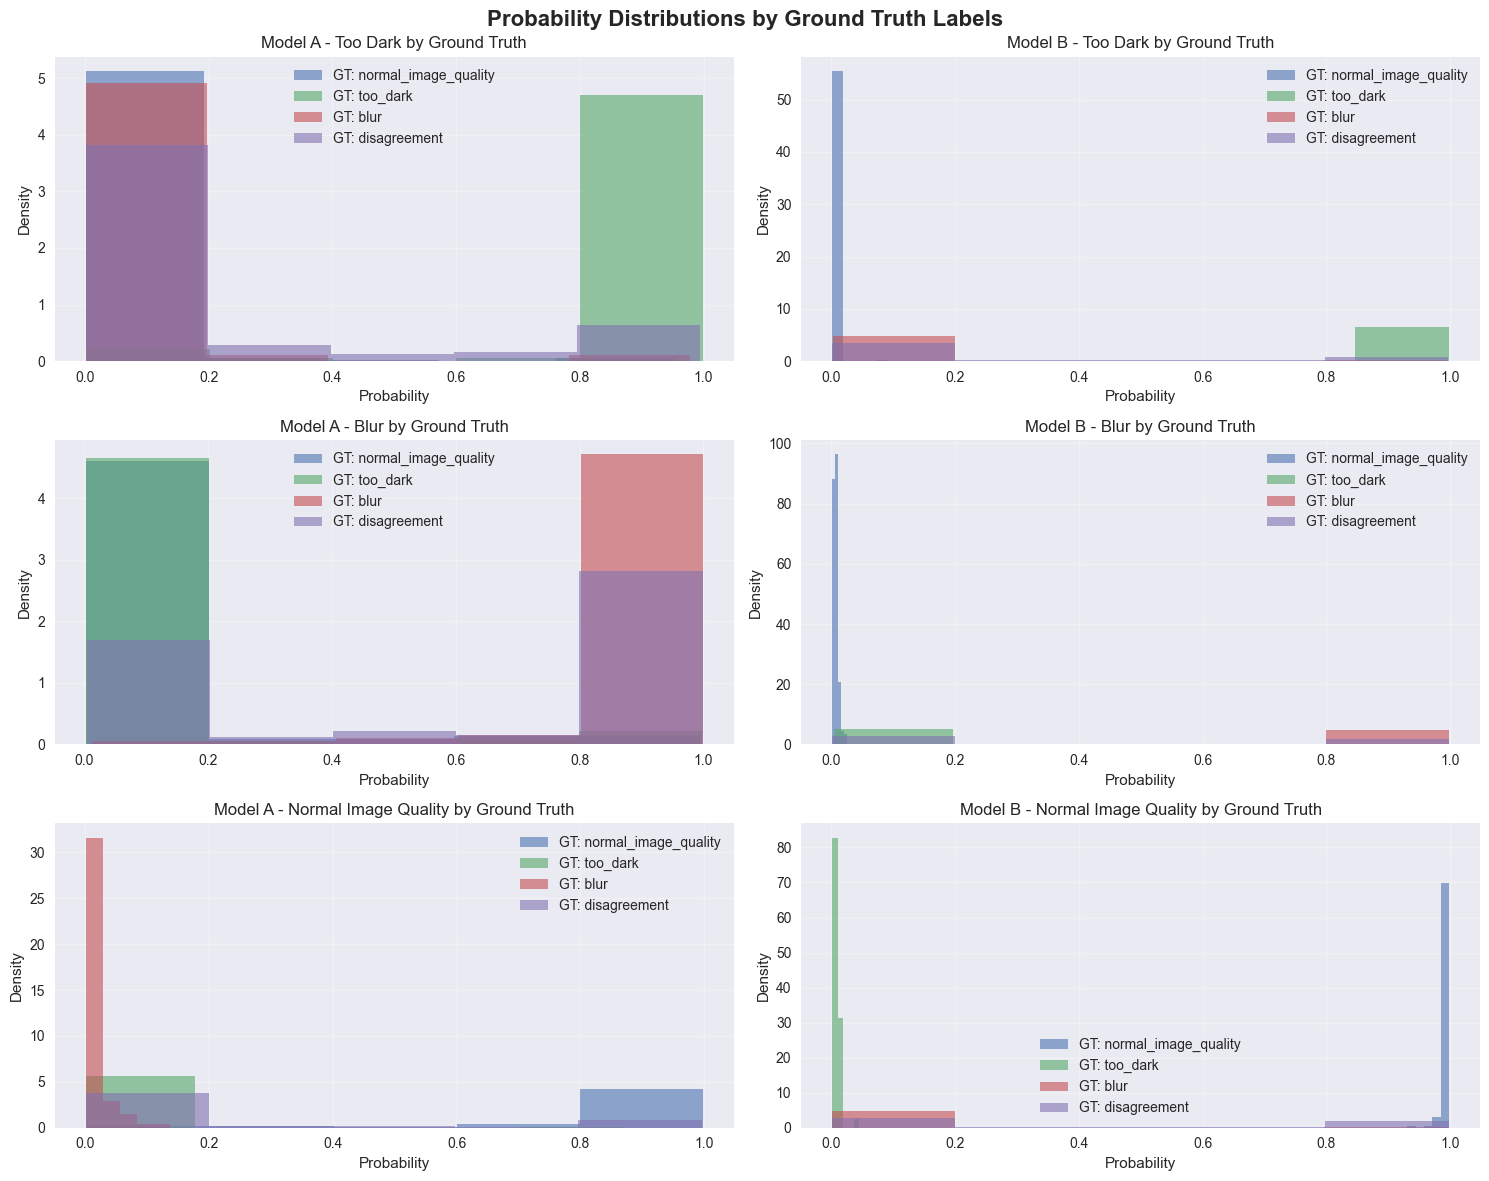

In [95]:
# DISTRIBUTION COMPARISON BY GROUND TRUTH
print(f"\n{'='*60}")
print("3. DISTRIBUTION BY GROUND TRUTH LABELS")
print("="*60)

# Create subplots for each class, split by ground truth
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Probability Distributions by Ground Truth Labels', fontsize=16, fontweight='bold')

for i, class_name in enumerate(classes):
    col_a = f'model_a_{class_name}'
    col_b = f'model_b_{class_name}'
    
    # Group by ground truth for Model A
    for gt_label in df['ground_truth'].unique():
        if pd.notna(gt_label):  # Skip NaN values
            subset = df[df['ground_truth'] == gt_label]
            axes[i, 0].hist(subset[col_a], bins=5, alpha=0.6, 
                           label=f'GT: {gt_label}', density=True)
    
    axes[i, 0].set_title(f'Model A - {class_name.replace("_", " ").title()} by Ground Truth')
    axes[i, 0].set_xlabel('Probability')
    axes[i, 0].set_ylabel('Density')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Group by ground truth for Model B
    for gt_label in df['ground_truth'].unique():
        if pd.notna(gt_label):  # Skip NaN values
            subset = df[df['ground_truth'] == gt_label]
            axes[i, 1].hist(subset[col_b], bins=5, alpha=0.6, 
                           label=f'GT: {gt_label}', density=True)
    
    axes[i, 1].set_title(f'Model B - {class_name.replace("_", " ").title()} by Ground Truth')
    axes[i, 1].set_xlabel('Probability')
    axes[i, 1].set_ylabel('Density')
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [96]:
# EXTREME VALUES ANALYSIS
print(f"\n{'='*60}")
print("4. EXTREME VALUES ANALYSIS")
print("="*60)

def analyze_extreme_values(df, threshold_low=0.05, threshold_high=0.95):
    """Analyze extreme probability values"""
    extreme_analysis = []
    
    for class_name in classes:
        col_a = f'model_a_{class_name}'
        col_b = f'model_b_{class_name}'
        
        # Very low probabilities (< 5%)
        very_low_a = df[df[col_a] < threshold_low]
        very_low_b = df[df[col_b] < threshold_low]
        
        # Very high probabilities (> 95%)
        very_high_a = df[df[col_a] > threshold_high]
        very_high_b = df[df[col_b] > threshold_high]
        
        extreme_analysis.append({
            'Class': class_name,
            'Model_A_Very_Low': len(very_low_a),
            'Model_B_Very_Low': len(very_low_b),
            'Model_A_Very_High': len(very_high_a),
            'Model_B_Very_High': len(very_high_b),
            'Model_A_Mean': df[col_a].mean(),
            'Model_B_Mean': df[col_b].mean(),
            'Model_A_Std': df[col_a].std(),
            'Model_B_Std': df[col_b].std()
        })
    
    return pd.DataFrame(extreme_analysis)

extreme_df = analyze_extreme_values(df)
print("EXTREME VALUES ANALYSIS:")
print(extreme_df.round(4).to_string(index=False))


4. EXTREME VALUES ANALYSIS
EXTREME VALUES ANALYSIS:
               Class  Model_A_Very_Low  Model_B_Very_Low  Model_A_Very_High  Model_B_Very_High  Model_A_Mean  Model_B_Mean  Model_A_Std  Model_B_Std
            too_dark               374               372                103                107         0.235         0.253        0.396        0.409
                blur               292               349                181                135         0.394         0.306        0.460        0.436
normal_image_quality               292               263                157                243         0.378         0.475        0.450        0.483



5. MODEL CORRELATION ANALYSIS
CORRELATION BETWEEN MODEL A AND MODEL B BY CLASS:
               Class  Correlation
            too_dark        0.822
                blur        0.801
normal_image_quality        0.829


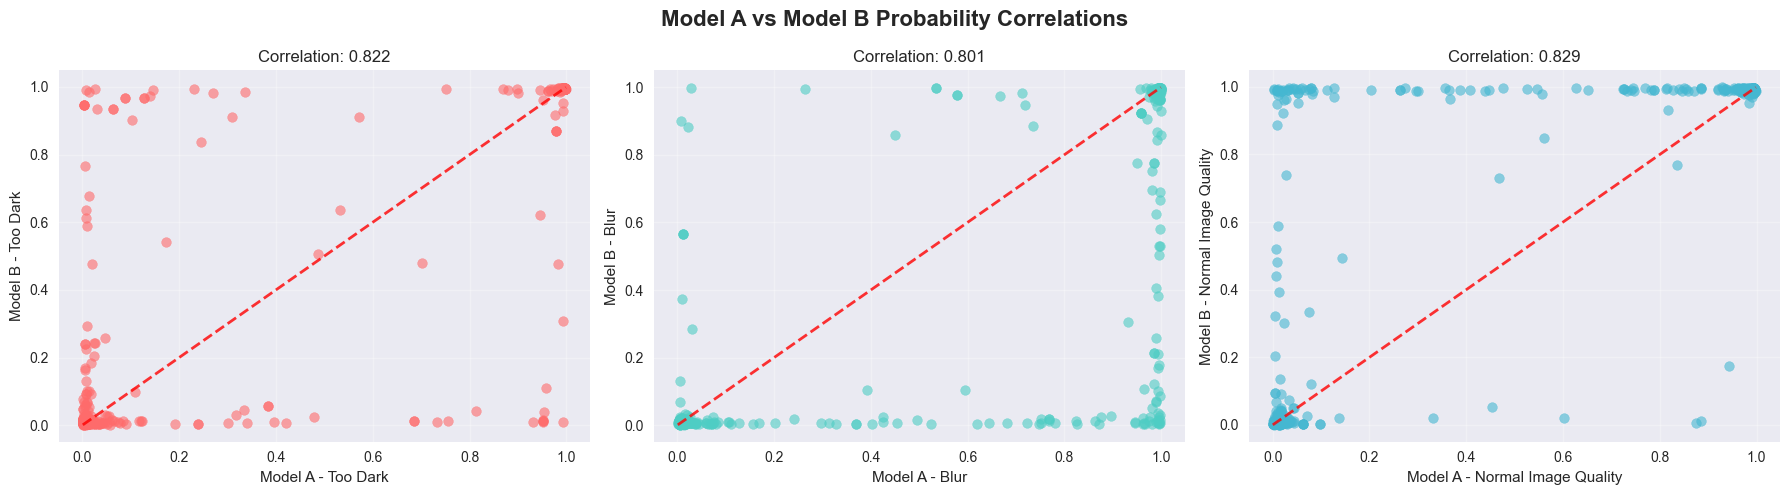

In [97]:
# Correlation analysis between models to evaluate model agreement and calibration similarity

print(f"\n{'='*60}")
print("5. MODEL CORRELATION ANALYSIS")
print("="*60)

# Calculate correlations between corresponding classes
correlations = []
for class_name in classes:
    col_a = f'model_a_{class_name}'
    col_b = f'model_b_{class_name}'
    
    correlation = df[col_a].corr(df[col_b])
    correlations.append({
        'Class': class_name,
        'Correlation': correlation
    })

corr_df = pd.DataFrame(correlations)
print("CORRELATION BETWEEN MODEL A AND MODEL B BY CLASS:")
print(corr_df.round(4).to_string(index=False))

# Scatter plots for correlation visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model A vs Model B Probability Correlations', fontsize=16, fontweight='bold')

for i, class_name in enumerate(classes):
    col_a = f'model_a_{class_name}'
    col_b = f'model_b_{class_name}'
    
    axes[i].scatter(df[col_a], df[col_b], alpha=0.6, color=colors[i])
    axes[i].set_xlabel(f'Model A - {class_name.replace("_", " ").title()}')
    axes[i].set_ylabel(f'Model B - {class_name.replace("_", " ").title()}')
    axes[i].set_title(f'Correlation: {df[col_a].corr(df[col_b]):.3f}')
    axes[i].grid(True, alpha=0.3)
    
    # Add diagonal line for perfect correlation
    min_val = min(df[col_a].min(), df[col_b].min())
    max_val = max(df[col_a].max(), df[col_b].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

In [98]:
# IDENTIFY SPECIFIC OUTLIER CASES

#define model predictions based on the highest probabilty values for both models

df['model_a_pred'] = df[['model_a_too_dark', 'model_a_blur', 'model_a_normal_image_quality']].idxmax(axis=1).str.replace('model_a_', '')
df['model_b_pred'] = df[['model_b_too_dark', 'model_b_blur', 'model_b_normal_image_quality']].idxmax(axis=1).str.replace('model_b_', '')

print(f"\n{'='*60}")
print("6. SPECIFIC OUTLIER CASES FOR INVESTIGATION")
print("="*60)

# Find cases where models have very different probability distributions
def find_disagreement_cases(df, threshold=0.5):
    """Find cases where models strongly disagree on probabilities"""
    disagreement_cases = []
    
    for idx, row in df.iterrows():
        for class_name in classes:
            col_a = f'model_a_{class_name}'
            col_b = f'model_b_{class_name}'
            
            diff = abs(row[col_a] - row[col_b])
            if diff > threshold:
                disagreement_cases.append({
                    'Index': idx,
                    'Class': class_name,
                    'Model_A_Prob': row[col_a],
                    'Model_B_Prob': row[col_b],
                    'Difference': diff,
                    'Ground_Truth': row.get('ground_truth', 'Unknown'),
                    'Model_A_Pred': row.get('model_a_pred', 'Unknown'),
                    'Model_B_Pred': row.get('model_b_pred', 'Unknown')
                })
    
    return pd.DataFrame(disagreement_cases)

# Find top disagreement cases
disagreement_df = find_disagreement_cases(df, threshold=0.5)
print("Number of Disagreement cases(Probability difference > 0.5):", len(disagreement_df))
if len(disagreement_df) > 0:
    print("TOP 10 DISAGREEMENT CASES (Probability difference > 0.5):")
    top_disagreements = disagreement_df.nlargest(10, 'Difference')
    print(top_disagreements.to_string(index=False))
else:
    print("No major disagreement cases found (threshold = 0.5)")




6. SPECIFIC OUTLIER CASES FOR INVESTIGATION
Number of Disagreement cases(Probability difference > 0.5): 160
TOP 10 DISAGREEMENT CASES (Probability difference > 0.5):
 Index                Class  Model_A_Prob  Model_B_Prob  Difference         Ground_Truth Model_A_Pred         Model_B_Pred
   166                 blur         0.997         0.006       0.990             too_dark         blur             too_dark
   457                 blur         0.995         0.005       0.990         disagreement         blur normal_image_quality
   457 normal_image_quality         0.003         0.992       0.989         disagreement         blur normal_image_quality
   351                 blur         0.995         0.006       0.988 normal_image_quality         blur normal_image_quality
   207 normal_image_quality         0.003         0.991       0.988 normal_image_quality         blur normal_image_quality
   396                 blur         0.993         0.007       0.987         disagreement       

# Model Performance Comparison - Overall Metrics

In [99]:
# Filter to cases with labeller agreement for cleaner analysis
clean_data = df[df['agreement'] == True].copy()
print(f"Analysis on {len(clean_data)} images with labeller agreement")

#define model predictions based on the highest probabilty values for both models

clean_data['model_a_pred'] = clean_data[['model_a_too_dark', 'model_a_blur', 'model_a_normal_image_quality']].idxmax(axis=1).str.replace('model_a_', '')
clean_data['model_b_pred'] = clean_data[['model_b_too_dark', 'model_b_blur', 'model_b_normal_image_quality']].idxmax(axis=1).str.replace('model_b_', '')


Analysis on 379 images with labeller agreement



=== CONFUSION MATRICES ===


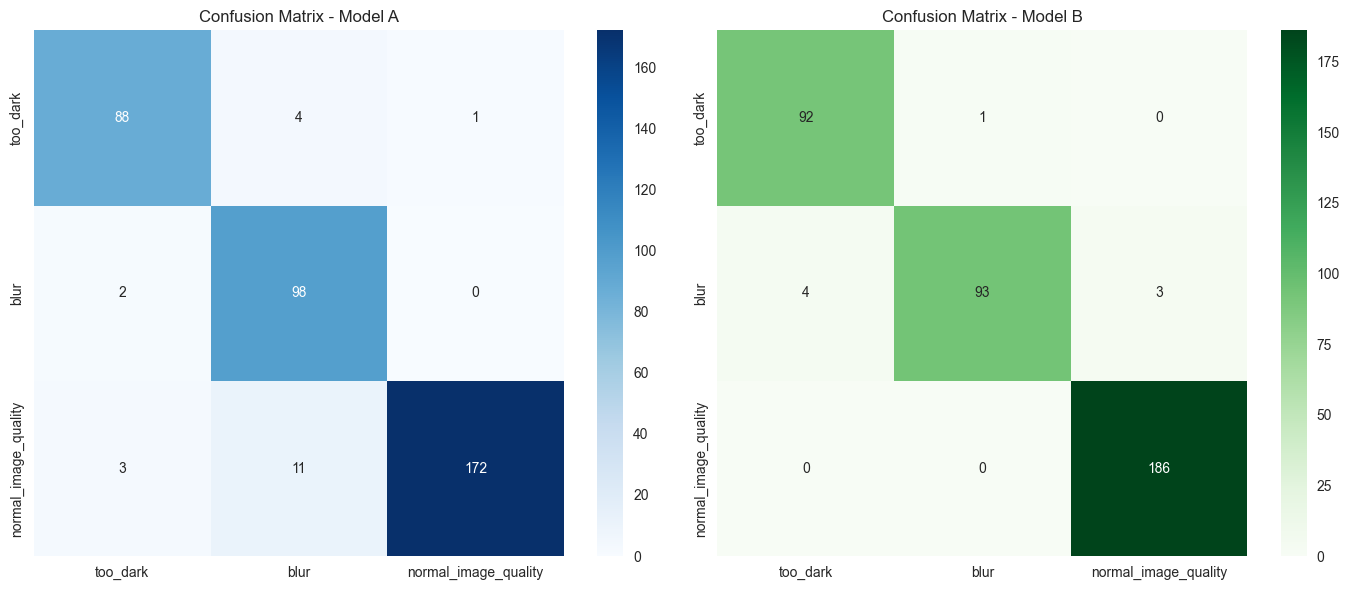

In [100]:
# confusion matrix for both models
print(f"\n=== CONFUSION MATRICES ===")
cm_A = confusion_matrix(clean_data['ground_truth'], clean_data['model_a_pred'], labels=['too_dark', 'blur', 'normal_image_quality'])
cm_B = confusion_matrix(clean_data['ground_truth'], clean_data['model_b_pred'], labels=['too_dark', 'blur', 'normal_image_quality'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_A, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['too_dark', 'blur', 'normal_image_quality'],
            yticklabels=['too_dark', 'blur', 'normal_image_quality'])
axes[0].set_title("Confusion Matrix - Model A")

sns.heatmap(cm_B, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['too_dark', 'blur', 'normal_image_quality'],
            yticklabels=['too_dark', 'blur', 'normal_image_quality'])
axes[1].set_title("Confusion Matrix - Model B")

plt.tight_layout()
plt.show()

In [101]:
# Calculate overall accuracy for both models
model_a_accuracy = accuracy_score(clean_data['ground_truth'], clean_data['model_a_pred'])
model_b_accuracy = accuracy_score(clean_data['ground_truth'], clean_data['model_b_pred'])
print(f"\n=== OVERALL ACCURACY ===")
print(f"Model A Accuracy: {model_a_accuracy:.3f}")
print(f"Model B Accuracy: {model_b_accuracy:.3f}")
print(f"Improvement: {(model_b_accuracy - model_a_accuracy)*100:.2f} percentage points")



=== OVERALL ACCURACY ===
Model A Accuracy: 0.945
Model B Accuracy: 0.979
Improvement: 3.43 percentage points


In [102]:
# Detailed classification reports
print(f"\n=== MODEL A CLASSIFICATION REPORT ===")
print(classification_report(clean_data['ground_truth'], clean_data['model_a_pred']))

print(f"\n=== MODEL B CLASSIFICATION REPORT ===")
print(classification_report(clean_data['ground_truth'], clean_data['model_b_pred']))


=== MODEL A CLASSIFICATION REPORT ===
                      precision    recall  f1-score   support

                blur       0.87      0.98      0.92       100
normal_image_quality       0.99      0.92      0.96       186
            too_dark       0.95      0.95      0.95        93

            accuracy                           0.94       379
           macro avg       0.94      0.95      0.94       379
        weighted avg       0.95      0.94      0.95       379


=== MODEL B CLASSIFICATION REPORT ===
                      precision    recall  f1-score   support

                blur       0.99      0.93      0.96       100
normal_image_quality       0.98      1.00      0.99       186
            too_dark       0.96      0.99      0.97        93

            accuracy                           0.98       379
           macro avg       0.98      0.97      0.97       379
        weighted avg       0.98      0.98      0.98       379



delivery vertical important metrics to observe

blur, dark : recall

normal : precision

# Class-Specific Performance Analysis

In [103]:
# Calculate precision, recall, F1 for each class
def calculate_metrics_by_class(y_true, y_pred, model_name):
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None, labels=['too_dark', 'blur', 'normal_image_quality'])
    
    metrics_df = pd.DataFrame({
        'Class': ['too_dark', 'blur', 'normal_image_quality '],
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support,
        'Model': model_name
    })
    return metrics_df

model_a_metrics = calculate_metrics_by_class(clean_data['ground_truth'], clean_data['model_a_pred'], 'Model A')
model_b_metrics = calculate_metrics_by_class(clean_data['ground_truth'], clean_data['model_b_pred'], 'Model B')


In [104]:
# Combine metrics for comparison
all_metrics = pd.concat([model_a_metrics, model_b_metrics])
print("=== CLASS-SPECIFIC PERFORMANCE METRICS ===")
print(all_metrics.round(2))

=== CLASS-SPECIFIC PERFORMANCE METRICS ===
                   Class  Precision  Recall  F1-Score  Support    Model
0               too_dark      0.950   0.950     0.950       93  Model A
1                   blur      0.870   0.980     0.920      100  Model A
2  normal_image_quality       0.990   0.920     0.960      186  Model A
0               too_dark      0.960   0.990     0.970       93  Model B
1                   blur      0.990   0.930     0.960      100  Model B
2  normal_image_quality       0.980   1.000     0.990      186  Model B


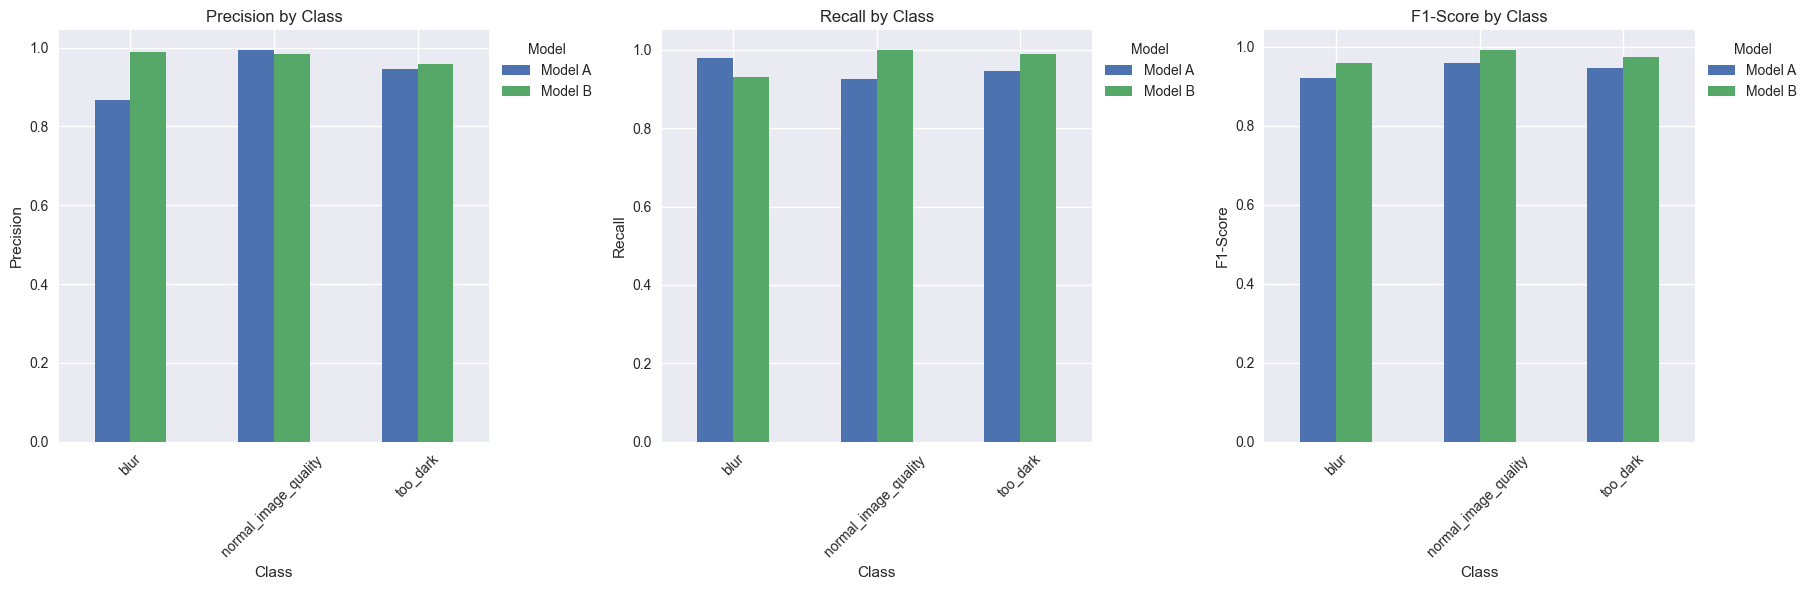

In [105]:
# Visualize performance comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # wider figure

metrics_to_plot = ['Precision', 'Recall', 'F1-Score']

for i, metric in enumerate(metrics_to_plot):
    pivot_data = all_metrics.pivot(index='Class', columns='Model', values=metric)
    pivot_data.plot(kind='bar', ax=axes[i], title=f'{metric} by Class')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=45)

    # Move legend outside
    axes[i].legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.subplots_adjust(right=0.85, wspace=0.4)  # Extra right space for legends
plt.show()

# Confidence Scores

In [123]:
# Analyze confidence scores for both models
print("=== CONFIDENCE SCORE ANALYSIS ===")

# Create confidence scores (max probability for each prediction)
clean_data['model_a_confidence'] = clean_data[['model_a_too_dark', 'model_a_blur', 'model_a_normal_image_quality']].max(axis=1)
clean_data['model_b_confidence'] = clean_data[['model_b_too_dark', 'model_b_blur', 'model_b_normal_image_quality']].max(axis=1)

print(f"Model A - Mean confidence: {clean_data['model_a_confidence'].mean():.3f}")
print(f"Model B - Mean confidence: {clean_data['model_b_confidence'].mean():.3f}")

=== CONFIDENCE SCORE ANALYSIS ===
Model A - Mean confidence: 0.956
Model B - Mean confidence: 0.990


# Labeller disagreement analysis


In [108]:
# Create confidence scores (max probability for each prediction)
df['model_a_confidence'] = df[['model_a_too_dark', 'model_a_blur', 'model_a_normal_image_quality']].max(axis=1)
df['model_b_confidence'] = df[['model_b_too_dark', 'model_b_blur', 'model_b_normal_image_quality']].max(axis=1)

def delivery_disagreement_analysis(df):
    """Analyze disagreements specifically for delivery vertical implications"""
    
    disagreed_labels = df[df['disagreement'] == True]
    print(f"=== DELIVERY DISAGREEMENT ANALYSIS ===")
    print(f"Ambiguous cases: {len(disagreed_labels)} ({len(disagreed_labels)/len(df):.1%} of dataset)")
    
    # For delivery, focus on high-risk disagreements
    # Case 1: One says normal, other flags issue (HIGHEST RISK)
    risky_disagreements = disagreed_labels[
        ((disagreed_labels['labeller1_label'] == 'normal') & 
         (disagreed_labels['labeller2_label'].isin(['blur', 'too_dark']))) |
        ((disagreed_labels['labeller2_label'] == 'normal') & 
         (disagreed_labels['labeller1_label'].isin(['blur', 'too_dark'])))
    ]
    
    print(f"HIGH-RISK disagreements (normal vs issue): {len(risky_disagreements)}")
    
    # How do models handle these critical edge cases?
    print(f"\n=== MODEL BEHAVIOR ON HIGH-RISK CASES ===")
    
    for model in ['model_a', 'model_b']:
        # Model accepts risky cases (predicts normal when there's disagreement about quality)
        accepts_risky = (risky_disagreements[f'{model}_pred'] == 'normal_image_quality').sum()
        avg_confidence = risky_disagreements[risky_disagreements[f'{model}_pred'] == 'normal_image_quality'][f'{model}_confidence'].mean()
        
        print(f"{model.upper()}:")
        print(f"  Accepts {accepts_risky}/{len(risky_disagreements)} risky cases ({accepts_risky/len(risky_disagreements):.1%})")
        print(f"  Average confidence on accepted risky cases: {avg_confidence:.3f}")
    
    # Case 2: Blur vs too_dark disagreements (lower risk but still important)
    quality_disagreements = disagreed_labels[
        ((disagreed_labels['labeller1_label'] == 'blur') & 
         (disagreed_labels['labeller2_label'] == 'too_dark')) |
        ((disagreed_labels['labeller2_label'] == 'blur') & 
         (disagreed_labels['labeller1_label'] == 'too_dark'))
    ]
    
    print(f"\nQuality-type disagreements (blur vs too_dark): {len(quality_disagreements)}")
    
    # Model consistency on quality issue type
    for model in ['model_a', 'model_b']:
        quality_preds = quality_disagreements[f'{model}_pred'].value_counts()
        print(f"{model.upper()} predictions on blur/dark disagreements:")
        print(quality_preds)
    
    return risky_disagreements, quality_disagreements

risky_cases, quality_cases = delivery_disagreement_analysis(df)

=== DELIVERY DISAGREEMENT ANALYSIS ===
Ambiguous cases: 157 (29.3% of dataset)
HIGH-RISK disagreements (normal vs issue): 117

=== MODEL BEHAVIOR ON HIGH-RISK CASES ===
MODEL_A:
  Accepts 33/117 risky cases (28.2%)
  Average confidence on accepted risky cases: 0.895
MODEL_B:
  Accepts 63/117 risky cases (53.8%)
  Average confidence on accepted risky cases: 0.958

Quality-type disagreements (blur vs too_dark): 40
MODEL_A predictions on blur/dark disagreements:
model_a_pred
blur        30
too_dark    10
Name: count, dtype: int64
MODEL_B predictions on blur/dark disagreements:
model_b_pred
too_dark                20
blur                    18
normal_image_quality     2
Name: count, dtype: int64


 # Business Impact Analysis for Delivery Vertical

In [114]:
# Delivery vertical specific analysis
print("=== BUSINESS IMPACT ANALYSIS FOR DELIVERY VERTICAL ===")

# For delivery: False negatives (poor quality flagged as normal) are costly
# False positives (normal flagged as poor) cause driver inconvenience

# Calculate business-relevant error rates
def calculate_business_metrics(y_true, y_pred, model_name):
    # Convert to binary: normal vs not_normal (too_dark/blur)
    y_true_binary = ['normal_image_quality' if x == 'normal_image_quality' else 'poor_quality' for x in y_true]
    y_pred_binary = ['normal_image_quality' if x == 'normal_image_quality' else 'poor_quality' for x in y_pred]
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary, labels=['normal_image_quality', 'poor_quality'])
    
    tn, fp, fn, tp = cm.ravel()
    
    # Business metrics
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0  # Poor quality passed as normal
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0  # Normal flagged as poor
    
    return {
        'Model': model_name,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'False_Negative_Rate': false_negative_rate,  # Critical for delivery
        'False_Positive_Rate': false_positive_rate   # Driver inconvenience
    }

business_metrics_a = calculate_business_metrics(clean_data['ground_truth'], clean_data['model_a_pred'], 'Model A')
business_metrics_b = calculate_business_metrics(clean_data['ground_truth'], clean_data['model_b_pred'], 'Model B')

business_comparison = pd.DataFrame([business_metrics_a, business_metrics_b])
print("Business Impact Metrics:")
print(business_comparison.round(4))

=== BUSINESS IMPACT ANALYSIS FOR DELIVERY VERTICAL ===
Business Impact Metrics:
     Model   TN  FP  FN   TP  False_Negative_Rate  False_Positive_Rate
0  Model A  172  14   1  192                0.005                0.075
1  Model B  186   0   3  190                0.015                0.000


# Edge Case Analysis & Model Disagreements

In [115]:
# Analyze cases where models disagree
print("=== MODEL DISAGREEMENT ANALYSIS ===")

model_disagreements = clean_data[clean_data['model_a_pred'] != clean_data['model_b_pred']]
print(f"Cases where models disagree: {len(model_disagreements)} ({len(model_disagreements)/len(clean_data)*100:.1f}%)")

if len(model_disagreements) > 0:
    print("\nDisagreement patterns:")
    disagreement_patterns = model_disagreements.groupby(['model_a_pred', 'model_b_pred']).size().reset_index(name='count')
    print(disagreement_patterns)

=== MODEL DISAGREEMENT ANALYSIS ===
Cases where models disagree: 23 (6.1%)

Disagreement patterns:
           model_a_pred          model_b_pred  count
0                  blur  normal_image_quality     14
1                  blur              too_dark      5
2  normal_image_quality              too_dark      1
3              too_dark  normal_image_quality      3


In [116]:
# Analyze confidence in disagreement cases
print(f"\nConfidence in disagreement cases:")
print(f"Model A avg confidence: {model_disagreements['model_a_confidence'].mean():.3f}")
print(f"Model B avg confidence: {model_disagreements['model_b_confidence'].mean():.3f}")


Confidence in disagreement cases:
Model A avg confidence: 0.819
Model B avg confidence: 0.969


In [117]:
# Which model is more often correct in disagreements?
a_correct_in_disagreement = (model_disagreements['model_a_pred'] == model_disagreements['ground_truth']).sum()
b_correct_in_disagreement = (model_disagreements['model_b_pred'] == model_disagreements['ground_truth']).sum()
print(f"\nIn disagreement cases:")
print(f"Model A correct: {a_correct_in_disagreement}/{len(model_disagreements)} ({a_correct_in_disagreement/len(model_disagreements)*100:.1f}%)")
print(f"Model B correct: {b_correct_in_disagreement}/{len(model_disagreements)} ({b_correct_in_disagreement/len(model_disagreements)*100:.1f}%)")


In disagreement cases:
Model A correct: 5/23 (21.7%)
Model B correct: 18/23 (78.3%)


In [118]:
# Identify high-confidence wrong predictions (concerning cases)
high_conf_wrong_a = clean_data[(clean_data['model_a_confidence'] > 0.9) & 
                               (clean_data['model_a_pred'] != clean_data['ground_truth'])]
high_conf_wrong_b = clean_data[(clean_data['model_b_confidence'] > 0.9) & 
                               (clean_data['model_b_pred'] != clean_data['ground_truth'])]

print(f"\nHigh-confidence wrong predictions (>90% confidence):")
print(f"Model A: {len(high_conf_wrong_a)} cases")
print(f"Model B: {len(high_conf_wrong_b)} cases")


High-confidence wrong predictions (>90% confidence):
Model A: 11 cases
Model B: 6 cases


# Recommendation Framework & Decision Matrix

In [ ]:
print("=== DECISION FRAMEWORK & RECOMMENDATION ===")

# Create decision matrix
decision_factors = {
    'Factor': [
        'Overall Accuracy',
        'False Negative Rate (Critical)',
        'False Positive Rate', 
        'Model Confidence',
        'Deployment Risk',
    ],
    'Model A': [
        f"{model_a_accuracy:.3f}",
        f"{business_metrics_a['False_Negative_Rate']:.3f}",
        f"{business_metrics_a['False_Positive_Rate']:.3f}",
        f"{clean_data['model_a_confidence'].mean():.3f}",
        "Low (already deployed)"
    ],
    'Model B': [
        f"{model_b_accuracy:.3f}",
        f"{business_metrics_b['False_Negative_Rate']:.3f}",
        f"{business_metrics_b['False_Positive_Rate']:.3f}",
        f"{clean_data['model_b_confidence'].mean():.3f}",
        "Medium (new deployment)"
    ],
    'Winner': [
        'Model B' if model_b_accuracy > model_a_accuracy else 'Model A',
        'Model B' if business_metrics_b['False_Negative_Rate'] < business_metrics_a['False_Negative_Rate'] else 'Model A',
        'Model B' if business_metrics_b['False_Positive_Rate'] < business_metrics_a['False_Positive_Rate'] else 'Model A',
        'Model B' if clean_data['model_b_confidence'].mean() > clean_data['model_a_confidence'].mean() else 'Model A',
        'Model A'
    ]
}

decision_df = pd.DataFrame(decision_factors)
print("Decision Matrix:")
print(decision_df.to_string(index=False))

# Final recommendation logic
accuracy_improvement = model_b_accuracy - model_a_accuracy
fnr_improvement = business_metrics_a['False_Negative_Rate'] - business_metrics_b['False_Negative_Rate']

print(f"\n=== FINAL RECOMMENDATION ===")
if accuracy_improvement > 0.02 and fnr_improvement > 0.01:  # Thresholds for meaningful improvement
    recommendation = "RECOMMEND MODEL B"
    confidence = "HIGH"
elif accuracy_improvement > 0.01:
    recommendation = "RECOMMEND MODEL B"  
    confidence = "MEDIUM"
else:
    recommendation = "STICK WITH MODEL A"
    confidence = "MEDIUM"

print(f"RECOMMENDATION: {recommendation}")
print(f"CONFIDENCE: {confidence}")
print(f"KEY REASONS:")
print(f"- Accuracy improvement: {accuracy_improvement*100:.2f} percentage points")
print(f"- False negative reduction: {fnr_improvement*100:.2f} percentage points")

# Implementation Roadmap & Risk Mitigation

In [ ]:
print("=== IMPLEMENTATION ROADMAP ===")

implementation_plan = """
PHASE 1: PREPARATION (Week 1-2)
- Set up A/B testing infrastructure
- Prepare rollback procedures
- Define success metrics and monitoring alerts

PHASE 2: PILOT DEPLOYMENT (Week 3-4)  
- Deploy Model B to 10% of delivery drivers
- Monitor key metrics: accuracy, driver complaints, dispute rates
- Collect feedback from drivers and customer service

PHASE 3: GRADUAL ROLLOUT (Week 5-8)
- If pilot successful, increase to 25%, then 50%, then 75%
- Continue monitoring and be ready to rollback
- Compare business metrics between Model A and B groups

PHASE 4: FULL DEPLOYMENT (Week 9-10)
- Complete rollout to all delivery drivers
- Decommission Model A infrastructure
- Document lessons learned
"""

print(implementation_plan)

print("\n=== RISK MITIGATION STRATEGIES ===")
risk_mitigation = """
HIGH RISK: Model B performs worse in production than test data
- Mitigation: Maintain A/B testing with quick rollback capability
- Monitor: Real-time accuracy metrics, customer complaints

MEDIUM RISK: Driver adoption issues with new model behavior  
- Mitigation: Driver training, clear communication about changes
- Monitor: Driver feedback, completion rates

LOW RISK: Technical deployment issues
- Mitigation: Staged rollout, thorough testing, rollback procedures
- Monitor: System performance, error rates
"""

print(risk_mitigation)

# Labelling Rubric for Edge Cases

In [ ]:
print("=== LABELLING RUBRIC FOR EDGE CASES ===")

labelling_rubric = """
CAPTUR DELIVERY PHOTO QUALITY LABELLING GUIDE

PURPOSE: Improve model training with consistent, high-quality labels

CLASSIFICATION CRITERIA:

1. TOO_DARK
   ✓ Subject matter not clearly visible due to insufficient lighting
   ✓ Critical details (package, address, surroundings) obscured by darkness
   ✗ Slightly dim but main subjects still clearly identifiable

2. BLUR  
   ✓ Motion blur, camera shake, or focus issues prevent clear identification
   ✓ Text on packages/addresses unreadable due to blur
   ✗ Minor blur that doesn't impact ability to verify delivery

3. NORMAL
   ✓ Clear, well-lit image suitable for delivery verification
   ✓ Package and delivery location clearly visible
   ✓ Could be used for dispute resolution if needed

EDGE CASE GUIDELINES:

→ BORDERLINE DARK/NORMAL: If you can clearly see the package and delivery location, choose NORMAL
→ BORDERLINE BLUR/NORMAL: If text is readable and package is identifiable, choose NORMAL  
→ MULTIPLE ISSUES: Choose the most severe quality issue (too_dark > blur > normal)
→ WHEN IN DOUBT: Consider: "Would this photo resolve a delivery dispute?" If yes → NORMAL

CONSISTENCY CHECKS:
- Review 10 random previous labels each session
- Discuss unclear cases with team lead
- Document new edge cases for future reference
"""

print(labelling_rubric)